# Economic Forecast Model Part 2: Generating Future Data (ARIMA)

**Goal:** In our previous article, we built a regression “engine” to predict Consumer Spending. Now, we need to manufacture the “fuel.”

**The Approach:** We use **quarterly** time-series forecasting (ARIMA). Instead of guessing, we let historical data forecast the **future economic inputs** (income, inflation, unemployment, and sentiment).

**Why do this?**
1. **Fuel for regression:** These forecasts provide the raw inputs required to power our spending prediction model.
2. **Standalone insight:** Even without the regression model, knowing where **inflation** or **unemployment** is headed is critical for strategic planning.

- **Frequency:** All data is resampled to **quarterly** averages to reduce noise and reveal stronger signals.
- **The “Big Five”:** We forecast income, inflation (CPI), unemployment, and sentiment. (We skip interest rates, since our regression model uses known past rates.)

# 1. Setup and Data Download

We start by installing the necessary tools. We will use **pmdarima**, a powerful library that automates the complex math of selecting the best model parameters (Auto-ARIMA).

We then connect to the **Federal Reserve (FRED)** to download the "Big Five" economic indicators: **Income**, **Inflation**, **Interest Rates**, **Sentiment**, and **Unemployment**. We resample this data to a quarterly frequency to match standard economic reporting.

We also snapshot the data to a local CSV file. This ensures our results remain consistent even if the government revises historical numbers later.

In [17]:
# @title 1. Setup and Data Download
# Install necessary libraries (if not already installed)
!pip install pmdarima pandas_datareader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import datetime
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option("display.float_format", lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = (12, 6)

# Define Dates
start_date = "2000-01-01"
end_date = datetime.date.today()

print("Downloading Data from FRED...")

# Define the "Big Five" (Our Friendly Name : FRED Series Code)
series_ids = {
    "Income": "DSPI",          # Real Disposable Personal Income
    "CPI": "CPIAUCSL",         # CPI Inflation
    "FedFunds": "FEDFUNDS",    # Interest Rates
    "Sentiment": "UMCSENT",    # Consumer Sentiment
    "Unrate": "UNRATE"         # Unemployment Rate
}

# Pull data and resample to QUARTERLY (QS)
df_raw = DataReader(list(series_ids.values()), "fred", start_date, end_date)
df_raw.columns = series_ids.keys()
df_q = df_raw.resample('QS').mean().dropna()

# ---------------------------------------------------------
# PRO TIP: Snapshot your data!
# In real-world data science, we save a local copy so our
# results don't change if the government revises past numbers.
# ---------------------------------------------------------
df_q.to_csv('economic_data_snapshot.csv')

print(f"Download complete. Loaded {len(df_q)} quarters of economic history.")
print("Data saved to 'economic_data_snapshot.csv'")
print(df_q.tail())

Download complete. Loaded 103 quarters of economic history.
Data saved to 'economic_data_snapshot.csv'
              Income     CPI  FedFunds  Sentiment  Unrate
DATE                                                     
2024-07-01 22002.567 314.183     5.263     68.133   4.167
2024-10-01 22249.500 316.539     4.650     72.100   4.133
2025-01-01 22563.700 319.492     4.330     64.467   4.133
2025-04-01 22786.600 320.800     4.330     55.033   4.200
2025-07-01 22945.400 323.288     4.293     58.333   4.333


# 2. Visualizing the Data (Stationarity Check)

Before modeling, we must visually inspect our data. ARIMA models require data to be "Stationary" (stable), but economic data often "Trends" (goes up forever).

* **Non-Stationary (Needs Fixing):** Variables like **Income** and **CPI** rise indefinitely. The model will need to use "Differencing" to make them usable.
* **Stationary/Cyclical:** Variables like **Unemployment** oscillate up and down, which is easier for the model to predict without modification.

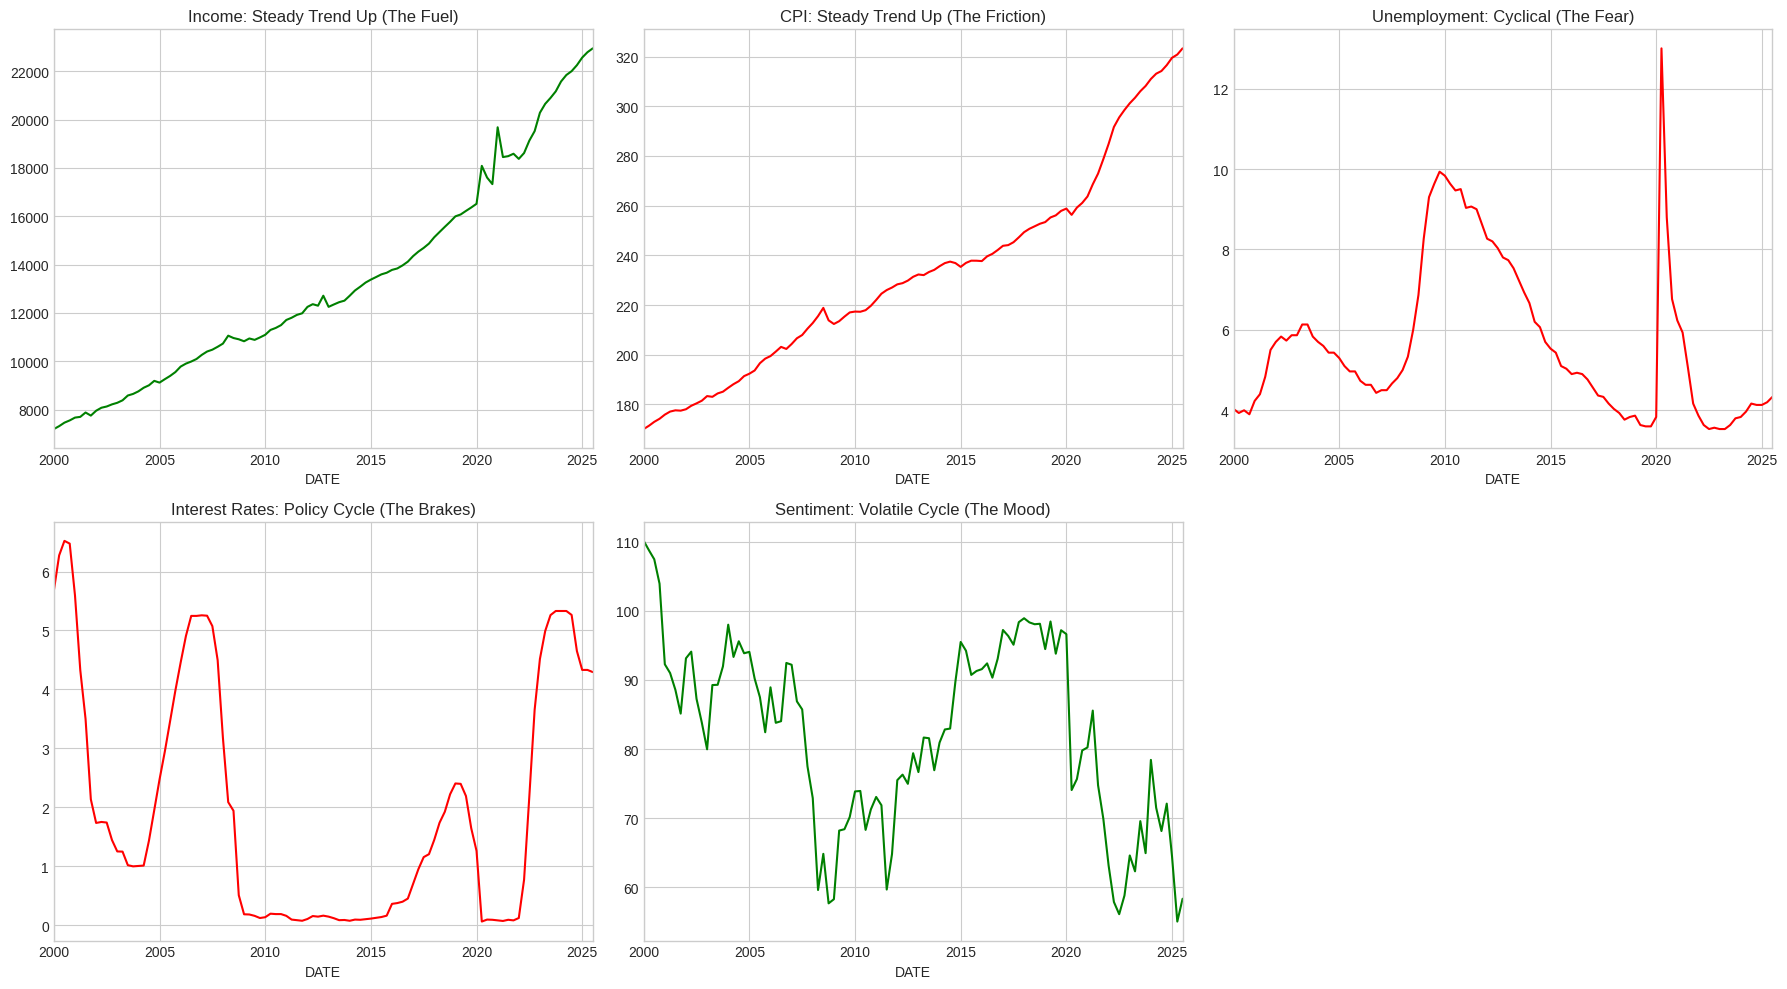

In [19]:
# @title 2. Visualizing Trends vs. Cycles
# We set up a 2x3 grid (Wider layout) to fit all variables to screen
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: The "Big Three" Macro Trends
df_q['Income'].plot(ax=axes[0,0], title='Income: Steady Trend Up (The Fuel)', color='green')
df_q['CPI'].plot(ax=axes[0,1], title='CPI: Steady Trend Up (The Friction)', color='red')
df_q['Unrate'].plot(ax=axes[0,2], title='Unemployment: Cyclical (The Fear)', color='red')

# Row 2: Policy & Psychology
df_q['FedFunds'].plot(ax=axes[1,0], title='Interest Rates: Policy Cycle (The Brakes)', color='red')
df_q['Sentiment'].plot(ax=axes[1,1], title='Sentiment: Volatile Cycle (The Mood)', color='green')

# Hide the 6th empty plot (Bottom right)
axes[1,2].set_visible(False)

plt.tight_layout()
plt.show()

# 3. Model Validation (Train/Test Split)

We split the data into **Training** (2000–2024) and **Test** (Last 4 Quarters).

**The Metrics:**
* **MAPE (% Error):** Good for big numbers like Income. "We were off by 0.5%."
* **MAE (Absolute Error):** Better for small rates like Unemployment. "We were off by 0.4 percentage points."

Training on 99 quarters. Testing on 4 quarters.

--- Validation Summary Table ---
               Order MAPE_Display    MAE
Variable                                
Income     (3, 2, 1)        0.31% 70.234
CPI        (1, 2, 1)        0.15%  0.485
Unrate     (1, 0, 0)       10.27%  0.433
Sentiment  (1, 0, 0)       16.78%  9.817
FedFunds   (3, 0, 0)        7.78%  0.342


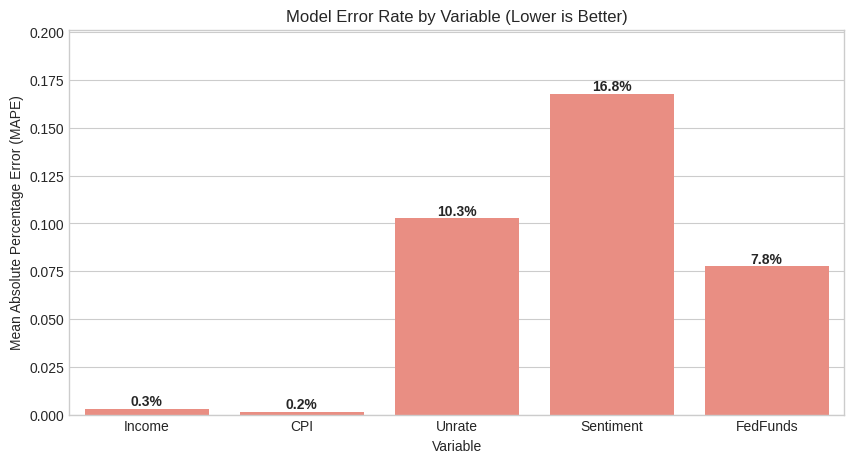

In [21]:
# @title 3. Run Validation Loop
test_len = 4  # Forecast horizon (1 Year)
train = df_q.iloc[:-test_len]
test = df_q.iloc[-test_len:]

print(f"Training on {len(train)} quarters. Testing on {len(test)} quarters.\n")

model_performance = []
# Include ALL 5 variables
vars_to_forecast = ['Income', 'CPI', 'Unrate', 'Sentiment', 'FedFunds']

for col in vars_to_forecast:
    # Fit Auto-ARIMA (seasonal=True, m=4 for Quarterly data)
    model = auto_arima(train[col], seasonal=True, m=4, stepwise=True,
                       suppress_warnings=True, error_action='ignore')

    # Predict
    forecast_test = model.predict(n_periods=test_len)

    # Score
    mape = mean_absolute_percentage_error(test[col], forecast_test)
    mae = mean_absolute_error(test[col], forecast_test)

    # Store results
    model_performance.append({
        'Variable': col,
        'MAPE': mape, # Keep raw number for plotting
        'MAE': mae,
        'Order': str(model.order)
    })

# --- Display Results ---

# 1. Create a clean Summary Table
perf_df = pd.DataFrame(model_performance).set_index('Variable')
perf_df['Accuracy'] = (1 - perf_df['MAPE']).map('{:.2%}'.format) # reliability score
perf_df['MAPE_Display'] = perf_df['MAPE'].map('{:.2%}'.format) # formatted string

print("--- Validation Summary Table ---")
print(perf_df[['Order', 'MAPE_Display', 'MAE']])

# 2. Plot the Error Rates (Visual Check)
plt.figure(figsize=(10, 5))
sns.barplot(x=perf_df.index, y=perf_df['MAPE'], color='salmon')
plt.title('Model Error Rate by Variable (Lower is Better)')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.ylim(0, max(perf_df['MAPE']) * 1.2) # Add some headroom
for i, v in enumerate(perf_df['MAPE']):
    plt.text(i, v, f"{v:.1%}", ha='center', va='bottom', fontweight='bold')
plt.show()

# 4. Visualizing Validation Results

Let's look at the "Proof of Concept" dashboard for **all five variables**.

* **Black Line (History):** The training data (zoomed in to the last 5 years).
* **Green Line (Actual):** What really happened in the economy.
* **Red Line (Predicted):** What our ARIMA model guessed would happen.

If the Red and Green lines are close, our model has passed the test.

Generating Validation Plots...
Plotting Income...
Plotting CPI...
Plotting Unrate...
Plotting Sentiment...
Plotting FedFunds...


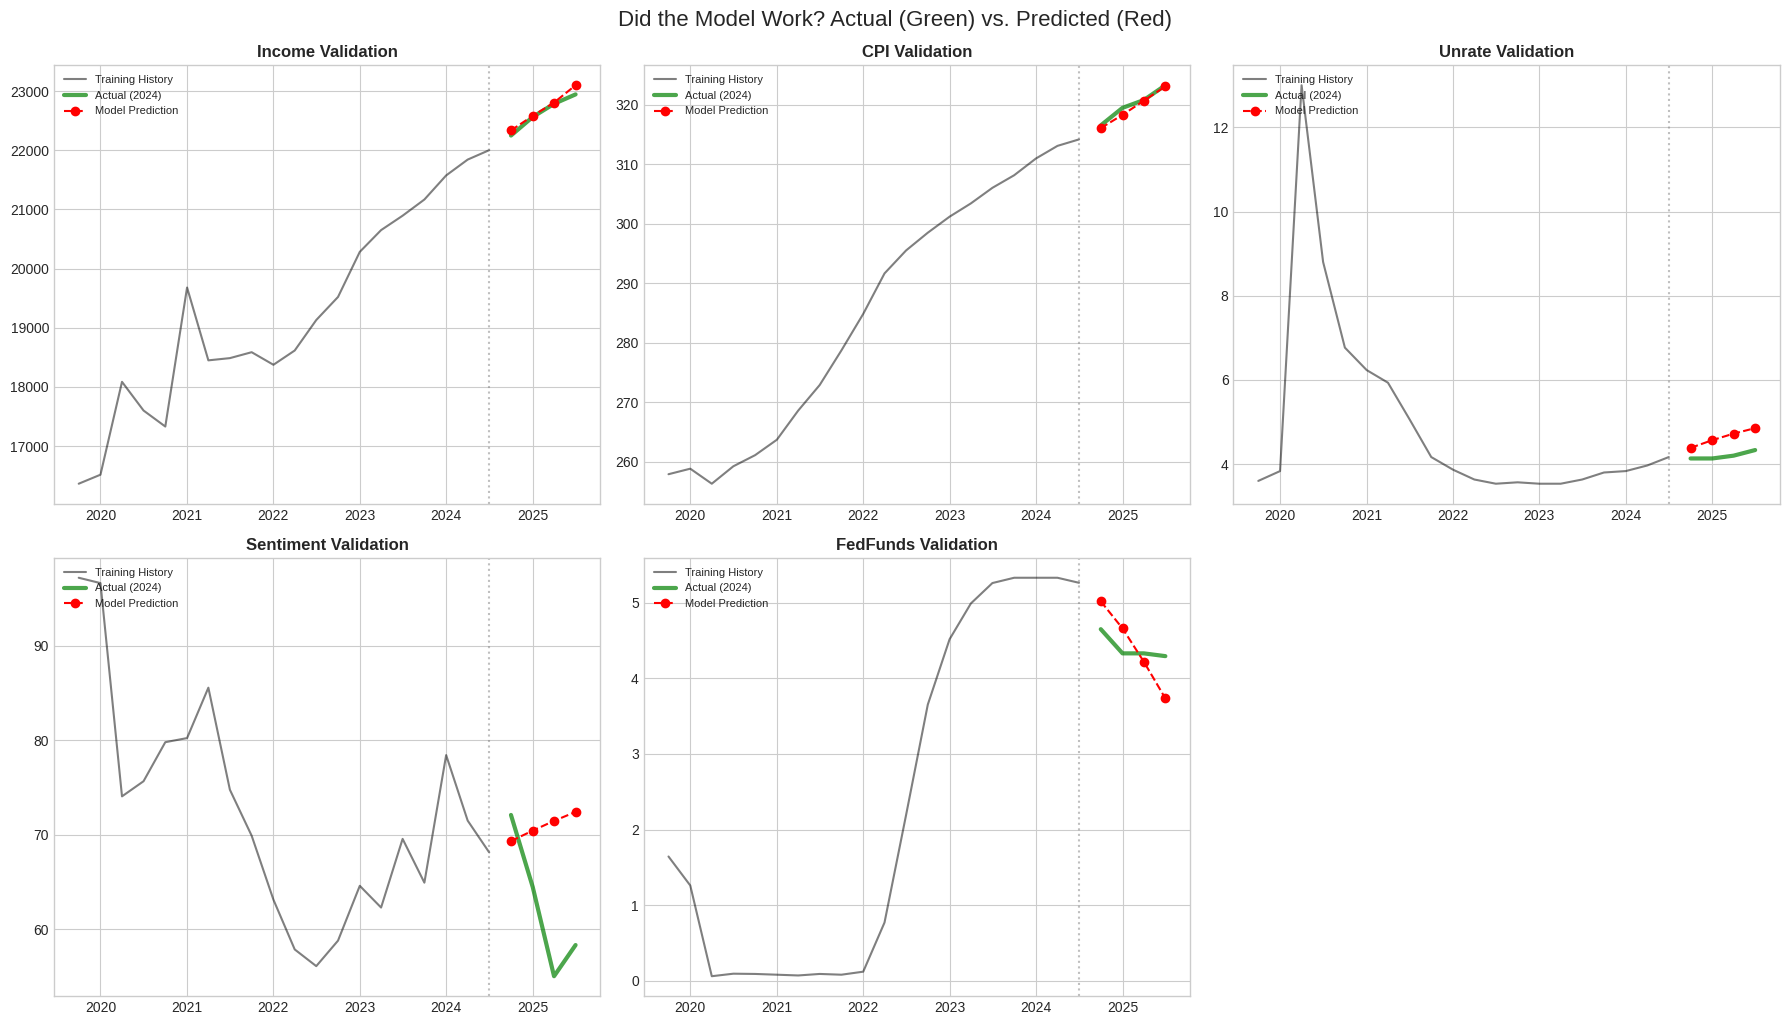

In [22]:
# @title 4. Plotting Actual vs. Predicted (All Variables)
# Setup the 2x3 Grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Flattens the 2D grid into a 1D list for easy looping

vars_to_forecast = ['Income', 'CPI', 'Unrate', 'Sentiment', 'FedFunds']

print("Generating Validation Plots...")

for i, col in enumerate(vars_to_forecast):
    print(f"Plotting {col}...")

    # 1. Re-fit the model on Training data (Same settings as Step 3)
    # We re-run this to ensure the plot matches our validation metrics perfectly
    model = auto_arima(train[col], seasonal=True, m=4,
                       suppress_warnings=True, error_action='ignore')

    # 2. Generate the Forecast
    forecast_test = model.predict(n_periods=test_len)

    # 3. Plot on the specific subplot axis
    ax = axes[i]

    # Plot History (Zoomed in to last 20 quarters for clarity)
    ax.plot(train.index[-20:], train[col].iloc[-20:], label="Training History", color='black', alpha=0.5)

    # Plot Reality (The Test Set)
    ax.plot(test.index, test[col], label="Actual (2024)", color='green', linewidth=3, alpha=0.7)

    # Plot Prediction
    ax.plot(test.index, forecast_test, label="Model Prediction", color='red', linestyle='--', marker='o')

    # Styling
    ax.set_title(f"{col} Validation", fontsize=12, fontweight='bold')
    ax.axvline(train.index[-1], color='gray', linestyle=':', alpha=0.5)
    ax.legend(loc='upper left', fontsize=8)

# Hide the 6th empty plot
axes[5].set_visible(False)

plt.tight_layout()
plt.suptitle("Did the Model Work? Actual (Green) vs. Predicted (Red)", fontsize=16, y=1.02)
plt.show()

# 5. Generating the 2026 Forecast

We re-train on the full dataset to predict 2026.

**A Note on Limitations:**
ARIMA models assume that *future patterns will look like past patterns*. They cannot predict **"Structural Breaks"**—massive shifts caused by external shocks like a new pandemic, a trade war, or sudden policy changes. Treat this forecast as a "Baseline Scenario" (what happens if things keep going as they are), not a crystal ball.

In [24]:
# @title 5. Generate 2026 Forecasts
# Define the horizon (4 Quarters = 1 Year)
forecast_horizon = 4
future_dates = pd.date_range(start=df_q.index[-1], periods=forecast_horizon+1, freq='QS')[1:]

# Explicitly ensure we are forecasting all 5 variables
vars_to_forecast = ['Income', 'CPI', 'Unrate', 'Sentiment', 'FedFunds']

forecast_data = {}
conf_intervals = {}

print("Generating 2026 Production Forecasts...")

for col in vars_to_forecast:
    print(f"Forecasting {col}...")
    # CRITICAL: Use the same seasonal settings (m=4) as our validation step
    final_model = auto_arima(df_q[col], seasonal=True, m=4,
                             suppress_warnings=True, error_action='ignore')

    # Predict with Confidence Intervals
    pred, conf = final_model.predict(n_periods=forecast_horizon, return_conf_int=True)

    forecast_data[col] = pred.values
    conf_intervals[col] = conf

# Create the Final DataFrame
forecast_df = pd.DataFrame(forecast_data, index=future_dates)
print("\n--- Raw ARIMA Forecasts for 2026 ---")
print(forecast_df)

Generating 2026 Production Forecasts...
Forecasting Income...
Forecasting CPI...
Forecasting Unrate...
Forecasting Sentiment...
Forecasting FedFunds...

--- Raw ARIMA Forecasts for 2026 ---
              Income     CPI  Unrate  Sentiment  FedFunds
2025-10-01 23251.341 325.769   4.515     59.895     4.144
2026-01-01 23485.477 328.246   4.669     61.356     3.923
2026-04-01 23707.726 330.723   4.799     62.723     3.653
2026-07-01 23984.876 333.199   4.909     64.002     3.355


# 6. Visualization: The "Cone of Uncertainty" Dashboard

**Strategic Insight:** A forecast without risk analysis is just a guess. To make better decisions, we need to distinguish between what is *predictable* and what is *volatile*.

We will now generate a dashboard for **all five economic indicators**.
* **Blue Line:** The "Base Case" forecast (our model's best guess).
* **Shaded Blue Region:** The **95% Confidence Interval** (the "Risk Zone").

**How to read these charts:**
* **Narrow Cone (High Confidence):** If the shaded area is tight (like for **Income** or **CPI**), the model is highly certain. The trend is stable and predictable.
* **Wide Cone (Low Confidence):** If the shaded area is massive (like for **Sentiment**), the model is admitting uncertainty. This signals a "Watch Out" area where we should prepare for volatility.
* **Directional Signal:** Watch **Unemployment**. Even if the cone is wide, if the *entire* cone tilts upward, it is a strong signal that the trend is real, regardless of the exact number.

Plotting 2026 Forecasts with Confidence Intervals...


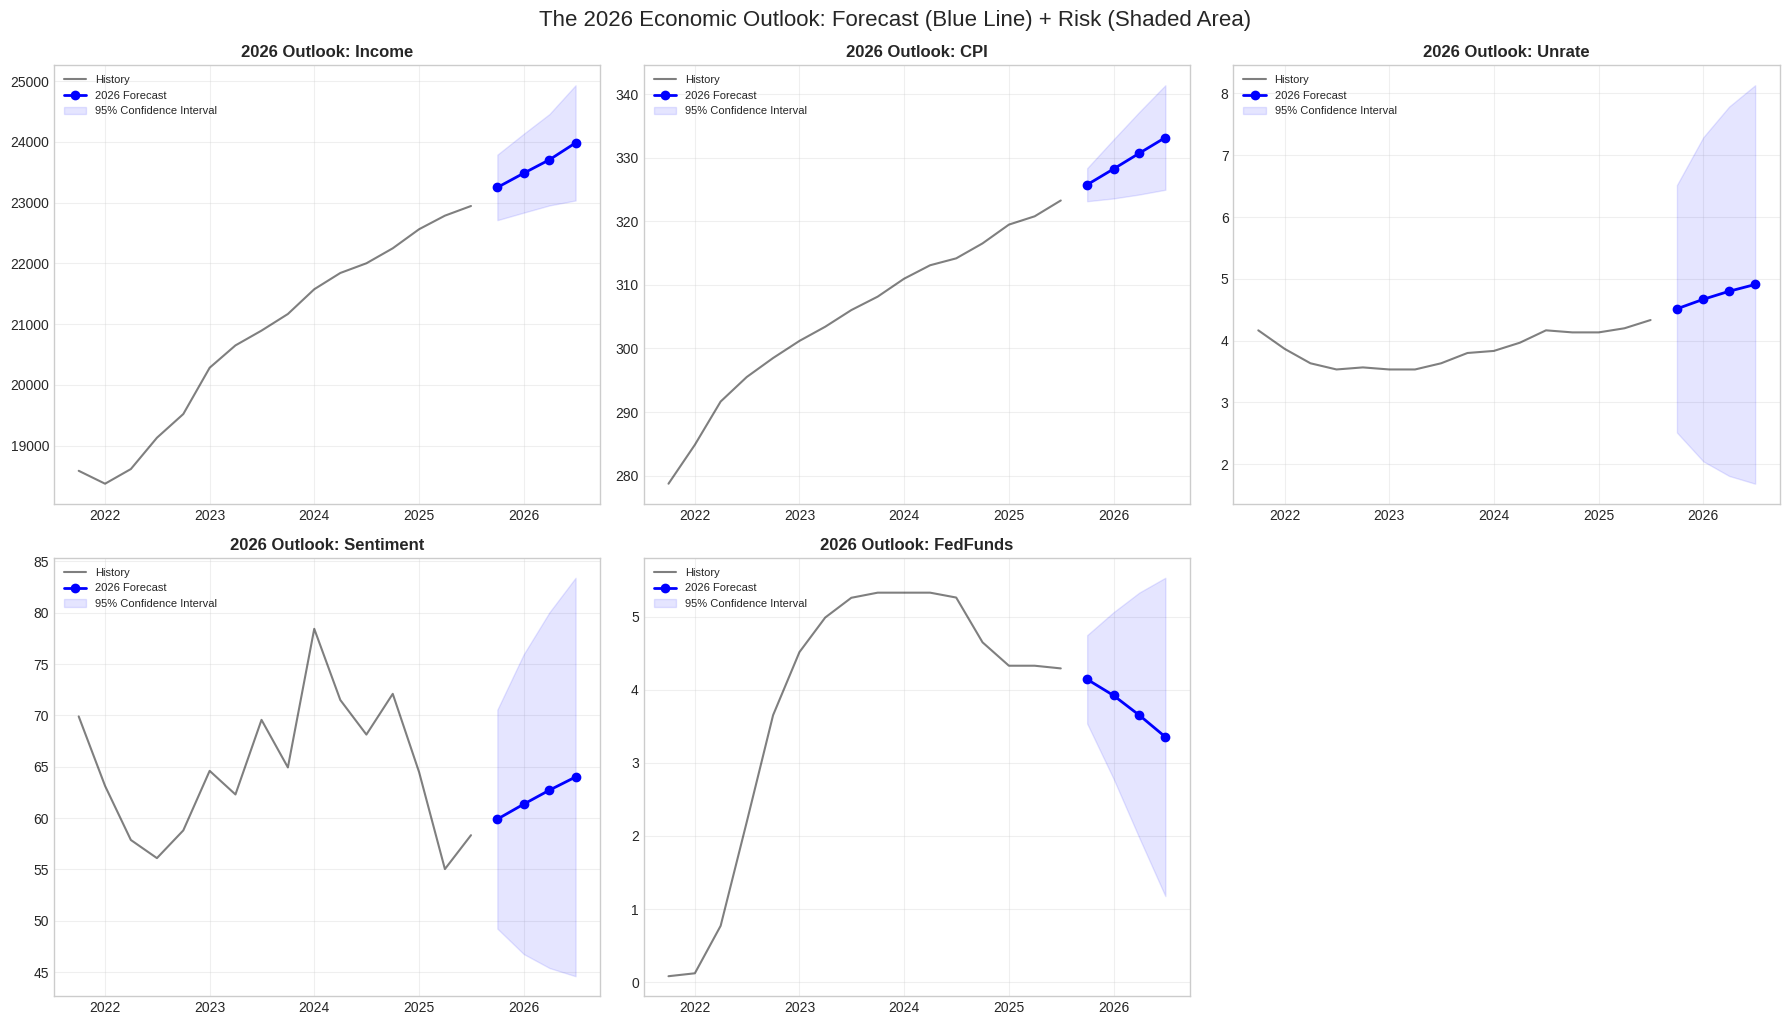

In [25]:
# @title 6. Plotting the 2026 Outlook (All Variables)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Ensure we have the list of variables (from Step 5)
vars_to_forecast = ['Income', 'CPI', 'Unrate', 'Sentiment', 'FedFunds']

print("Plotting 2026 Forecasts with Confidence Intervals...")

for i, col in enumerate(vars_to_forecast):
    ax = axes[i]

    # 1. Plot Historical Data (Zoomed into last 4 years for context)
    # We use -16 quarters to show the trend leading up to today
    history = df_q[col].iloc[-16:]
    ax.plot(history.index, history, label="History", color='black', alpha=0.5)

    # 2. Plot the Forecast Line (The "Base Case")
    # forecast_df was created in Step 5
    ax.plot(future_dates, forecast_df[col], label="2026 Forecast", color='blue', linewidth=2, marker='o')

    # 3. Plot the Confidence Interval (The "Cone")
    # conf_intervals[col] is a list of [lower, upper] arrays from Step 5
    lower_bound = conf_intervals[col][:, 0]
    upper_bound = conf_intervals[col][:, 1]

    ax.fill_between(future_dates, lower_bound, upper_bound,
                    color='blue', alpha=0.1, label="95% Confidence Interval")

    # Styling
    ax.set_title(f"2026 Outlook: {col}", fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the empty 6th plot (since we only have 5 variables)
axes[5].set_visible(False)

plt.tight_layout()
plt.suptitle("The 2026 Economic Outlook: Forecast (Blue Line) + Risk (Shaded Area)", fontsize=16, y=1.02)
plt.show()

# 7. The Hand-Off: Preparing Inputs for Regression

We now have raw forecasts, but our Regression model expects **Growth Rates**, **Differences**, and **Lags**.

In this final step, we transform the ARIMA data into the exact format required by our Regression model:
* **Income & Inflation:** Converted to Annualized Growth Rates.
* **Unemployment:** Converted to YoY Difference.
* **Sentiment:** Shifted by **1 Quarter** (3 Months).
* **Rates:** Shifted by **4 Quarters** (12 Months) — *using actual past rates.*

**Conceptual Note:**
These ARIMA forecasts provide **momentum-based inputs** (where the economy is heading). The Regression model will determine **impact** (how much those changes actually affect your sales).

**Output:** Copy the table below and paste it into your Regression Notebook as the `future_X` input.

In [26]:
# @title 7. Generate Baseline (Consensus) Data

# 1. Create a container for our final regression inputs
regression_inputs = pd.DataFrame(index=forecast_df.index)

# 2. Combine History + Forecast
# We need historical data to calculate growth rates and lags for the first few forecast periods.
combined_df = pd.concat([df_q, forecast_df])

# --- Transformations (Matching the Consumer Spending Model) ---

# Income & Inflation: Annualized Growth Rate (4 Quarters)
regression_inputs['Income_Growth'] = combined_df['Income'].pct_change(4).tail(forecast_horizon) * 100
regression_inputs['Inflation'] = combined_df['CPI'].pct_change(4).tail(forecast_horizon) * 100

# Unemployment: Year-over-Year Difference
regression_inputs['Unemployment_Change'] = combined_df['Unrate'].diff(4).tail(forecast_horizon)

# Sentiment: 1-Quarter Lag (Equivalent to 3 Months)
regression_inputs['Sentiment_Lag3'] = combined_df['Sentiment'].shift(1).tail(forecast_horizon)

# Rates: 4-Quarter Lag (Equivalent to 12 Months)
# We use ACTUAL rates from 1 year ago, so no forecasting needed here
regression_inputs['Rates_Lagged'] = combined_df['FedFunds'].shift(4).tail(forecast_horizon)

# Constant (Required for Statsmodels)
regression_inputs['const'] = 1.0

print("--- ARIMA BASELINE FORECAST (Quarterly) ---")
print(regression_inputs)
print("\n--- SUMMARY FOR SCENARIO INPUTS (Average over Horizon) ---")
print(regression_inputs.mean())

--- ARIMA BASELINE FORECAST (Quarterly) ---
            Income_Growth  Inflation  Unemployment_Change  Sentiment_Lag3  \
2025-10-01          4.503      2.916                0.382          58.333   
2026-01-01          4.085      2.740                0.535          59.895   
2026-04-01          4.042      3.093                0.599          61.356   
2026-07-01          4.530      3.066                0.575          62.723   

            Rates_Lagged  const  
2025-10-01         4.650  1.000  
2026-01-01         4.330  1.000  
2026-04-01         4.330  1.000  
2026-07-01         4.293  1.000  

--- SUMMARY FOR SCENARIO INPUTS (Average over Horizon) ---
Income_Growth          4.290
Inflation              2.954
Unemployment_Change    0.523
Sentiment_Lag3        60.577
Rates_Lagged           4.401
const                  1.000
dtype: float64
